# Проверка гипотезы в Python

## 1. Загрузка данных и знакомство с ними


In [1]:
#импортируем нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

In [39]:
#загружаем и просматриваем данные
yandex_knigi_data = pd.read_csv('https://code.s3.yandex.net/datasets/yandex_knigi_data.csv')
yandex_knigi_data.head(5)

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [3]:
#проверяем типы данных и пропуски
yandex_knigi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


In [4]:
#проверяем наличие дубликатов в столбце с id пользователей
yandex_knigi_data['puid'].duplicated().sum()

244

In [5]:
#удаляем дубликаты
yandex_knigi_cleaned = yandex_knigi_data.drop_duplicates('puid')

In [6]:
#выделяем из общего датафрейма группы по городам 
msk_users = yandex_knigi_cleaned[yandex_knigi_cleaned['city'] == 'Москва']
spb_users = yandex_knigi_cleaned[yandex_knigi_cleaned['city'] == 'Санкт-Петербург']

#считаем количество пользователей в каждом городе
msk_users_cnt = msk_users['puid'].nunique()
spb_users_cnt = spb_users['puid'].nunique()


print (f'В Москве: {msk_users_cnt} пользователей, в Санкт-Петербурге: {spb_users_cnt} пользователей')

В Москве: 6234 пользователей, в Санкт-Петербурге: 2306 пользователей


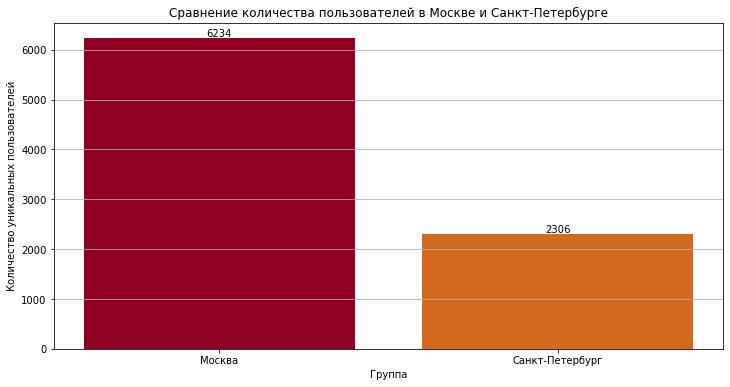

In [7]:
#строим столбчатую диаграмму по количеству пользователей в городах
plt.figure(figsize=(12, 6))

groups = ['Москва', 'Санкт-Петербург']
values = [msk_users_cnt, spb_users_cnt]

for i, v in enumerate(values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.bar(groups, values, color=['#900020', '#D2691E'])
plt.title('Сравнение количества пользователей в Москве и Санкт-Петербурге')
plt.xlabel('Группа')
plt.ylabel('Количество уникальных пользователей')
plt.grid(axis = 'y')
plt.show()

Видим, что наши данные содержат неравномерное распределение между городами: в Санкт-Петербурге почти втрое меньше пользователей. Это не помешает нам проверить гипотезу, но предварительно нужно проверить группы на независимость и нормальное распределение (далее). А пока посмотрим на статистики групп.

In [8]:
#посчитаем статистики для групп пользователей 
msk_users['hours'].describe()

count    6234.000000
mean       10.881092
std        36.851683
min         0.000018
25%         0.059903
50%         0.924498
75%         5.939972
max       857.209373
Name: hours, dtype: float64

In [9]:
spb_users['hours'].describe()

count    2306.000000
mean       11.264433
std        39.831755
min         0.000025
25%         0.060173
50%         0.875355
75%         6.138424
max       978.764775
Name: hours, dtype: float64

Данные в Москве и Санкт-Петербурге отличаются, но незначительно. Медианные значения выборок находятся близко. В Санкт-Петербурге выше стандартное отклонение, что может говорить о наличии выбросов. Статистики говорят о схожем поведении пользователей в городах. 

In [10]:
#создаем множество пользователей для проверки пересечений

users_msk_set = set(yandex_knigi_cleaned[yandex_knigi_cleaned['city'] == 'Москва']['puid'].unique())
users_spb_set = set(yandex_knigi_cleaned[yandex_knigi_cleaned['city'] == 'Санкт-Петербург']['puid'].unique())

#проверяем пересечение множеств
intersection = users_msk_set & users_spb_set

print(f"Пользователи, попавшие в обе группы: {len(intersection)}")

Пользователи, попавшие в обе группы: 0


Условие по независимости выборок выполнено ✅

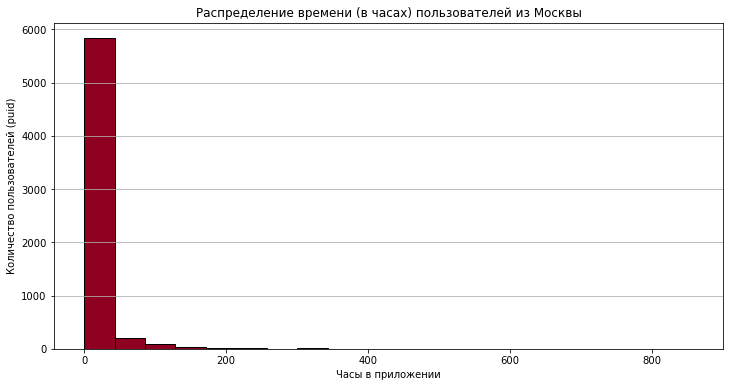

In [11]:
#строим гистограмму с распределением времени прослушивания для пользователей из Москвы
plt.figure(figsize=(12, 6))
plt.hist(msk_users['hours'], bins=20, color='#900020', edgecolor='black')
plt.title('Распределение времени (в часах) пользователей из Москвы')
plt.xlabel('Часы в приложении')
plt.ylabel('Количество пользователей (puid)')
plt.grid(axis='y')
plt.show()

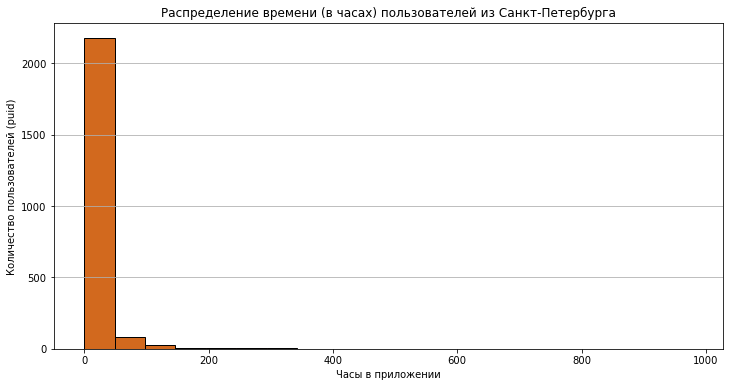

In [12]:
#строим гистограмму с распределением времени прослушивания для пользователей из Спб

plt.figure(figsize=(12, 6))
plt.hist(spb_users['hours'], bins=20, color='#D2691E', edgecolor='black')
plt.title('Распределение времени (в часах) пользователей из Санкт-Петербурга')
plt.xlabel('Часы в приложении')
plt.ylabel('Количество пользователей (puid)')
plt.grid(axis='y')
plt.show()

Построив гистограммы каждой выборки, видим, что данные сильно скошены вправо, а также содержат выбросы. Используем межквантильный размах, чтобы очистить выбросы. 

In [13]:
#вычислим квартильные значения
Q1 = msk_users['hours'].quantile(0.25)
Q3 = msk_users['hours'].quantile(0.75)
IQR = Q3 - Q1

# определим границы для "нормальных" значений
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# отфильтруем DataFrame
msk_users_filtered = msk_users[(msk_users['hours'] >= lower_bound) & (msk_users['hours'] <= upper_bound)]

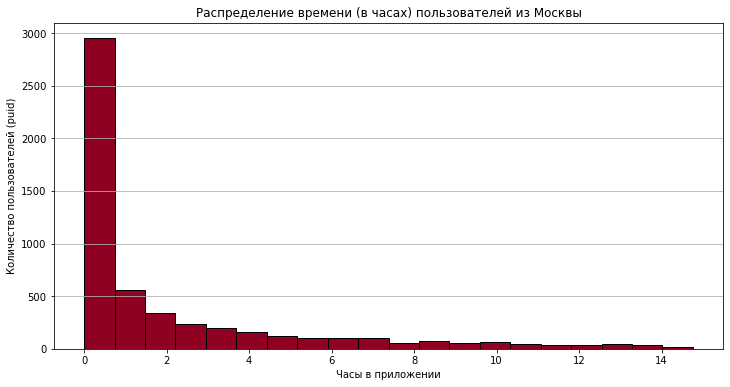

In [14]:
#построим гистограмму для "очищенных данных" по Москве
plt.figure(figsize=(12, 6))

plt.hist(msk_users_filtered['hours'], bins=20, color='#900020', edgecolor='black')
plt.title('Распределение времени (в часах) пользователей из Москвы')
plt.xlabel('Часы в приложении')
plt.ylabel('Количество пользователей (puid)')
plt.grid(axis='y')
plt.show()

In [15]:
#вычислим квартильные значения
Q1 = spb_users['hours'].quantile(0.25)
Q3 = spb_users['hours'].quantile(0.75)
IQR = Q3 - Q1

# определим границы для "нормальных" значений
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# отфильтруем DataFrame
spb_users_filtered = spb_users[(spb_users['hours'] >= lower_bound) & (spb_users['hours'] <= upper_bound)]

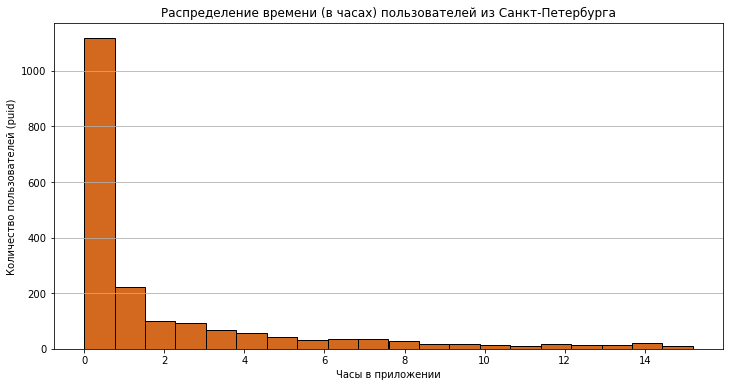

In [16]:
#построим гистограмму для "очищенных данных" по Спб
plt.figure(figsize=(12, 6))

plt.hist(spb_users_filtered['hours'], bins=20, color='#D2691E', edgecolor='black')
plt.title('Распределение времени (в часах) пользователей из Санкт-Петербурга')
plt.xlabel('Часы в приложении')
plt.ylabel('Количество пользователей (puid)')
plt.grid(axis='y')
plt.show()

Распределения пользователей в обоих городах сильно скошены вправо, и не являются нормальными распределениями. 
Основная масса значений находится в интервале в от 0 до 1 часа, т.е. большинство пользователей провели очень мало времени. С увеличением времени количество пользователей резко падает. Наблюдаются редкие случаи длительного использования (вплоть до 15 часов).

По результатам изучения данных было выявлено, что выборки не подвержены нормальному распределению, а значит, для проверки гипотезы будем использовать непараметрический тест Манна-Уитни. 

## 2. Проверка гипотезы в Python


- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [17]:
# на каком уровне значимости проверяем гипотезу о равенстве распределений
alpha = 0.05 

# выборка целевой метрики для группы A
metric_a = msk_users[msk_users.city=='Москва'].hours
# выборка целевой метрики для группы B
metric_b = spb_users[spb_users.city=='Санкт-Петербург'].hours

# применяем тест Манна — Уитни
stat_mw, p_value_mw = mannwhitneyu(
    metric_a, 
    metric_b, 
    alternative='less' # Альтернативная гипотеза двусторонняя
) 

if p_value_mw > alpha:
    print(f'pvalue={p_value_mw} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={p_value_mw} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=0.6189600878052618 > 0.05
Нулевая гипотеза находит подтверждение!


## 3. Аналитическая записка



В данном случае для проверки статистических гипотез был выбран непараметрический тест Манна-Уитни, так как выборки не имеют нормального распределения, а также содержат выбросы. 

Уровень статистической значимости: 0.05

На основании полученного значения p-value = 0.619, которое значительно превышает уровень значимости 0.05, у нас нет оснований отклонять нулевую гипотезу. Это означает, что **статистически значимой разницы в среднем времени активности между пользователями из Санкт-Петербурга и Москвы не выявлено.**

Возможные причины такого результата:

1. Разницы между группами действительно нет. Несмотря на незначительное различие в средних значениях, оно может быть случайным, а не обоснованным поведением пользователей из разных городов.

2. Наличие выбросов. В выборках наблюдаются высокие стандартные отклонения (37–40 часов) и экстремальные значения (максимумы около 900 часов). Это снижает чувствительность теста к небольшим сдвигам в среднем значении.